# Predicting the 2021-2022 NBA MVP Voting Race

Group Member 1: David Basin
Group Member 2: Mateo Castro
Group Member 3: Abed Islam
***

We will be attempting to determine who will win the NBA Most Valuable Player award using machine learning methods such as SVM/Linear Regression. Our findings will be based on the advanced analystics of past MVP winners, their teams and the advanced analytics of this years players. The datasets to be used are provided.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, linear_model, metrics
%matplotlib inline 

### Part 1: Acquiring and cleaning the data
We first obtained the team records for all years that we were using in our dataset (1977-present). We did this by getting team records from the league’s creation to 2017 from Kaggle, and the other individual years from Basketball Reference’s standings pages. We combined the two sources’ datasets into one data frame. We then created a data frame that contained the MVP voting data, and the per-game and advanced stats for each player in our selected years (all three of which came from BRef’s yearly data for each category). After a discussion about what features would be best, we decided to settle on 15 specific features to use in our model. Also featured in the data frame are player name, team name, and year of MVP vote.


In [2]:
team_records = pd.read_csv("Standings/Team_Records.csv") #Kaggle dataset w/team records before 2017
#Records for 17-18 season were incomplete, so we eliminated that from data set:
team_records = team_records.loc[team_records["Season"] != "2017-18"]
#Adding stats from standings csv's from bref (2017-18 to present)
for i in range(17,22):
    years = str(i)+"-"+str(i+1)
    east_standings = pd.read_csv("Standings/"+years+"_East.csv")
    west_standings = pd.read_csv("Standings/"+years+"_West.csv")
    team_records = pd.concat([team_records,east_standings,west_standings])
team_records["Season"] = team_records["Season"].str.slice(2) #Don't use the first two digits in year (i.e. 17 vs 2017)
team_records["Team"] = team_records["Team"].str.replace('*','',regex=False) #Take out extra *'s'
team_records.set_index(["Season","Team"],inplace=True)
#Dictionary of abbreviations to team names
team_dict = {"ATL":"Atlanta Hawks", "BRK":"Brooklyn Nets","BOS":"Boston Celtics","CHO":"Charlotte Hornets",
    "CHI":"Chicago Bulls","CLE":"Cleveland Cavaliers","DAL":"Dallas Mavericks","DEN":"Denver Nuggets",
    "DET":"Detroit Pistons","GSW":"Golden State Warriors","HOU":"Houston Rockets","IND":"Indiana Pacers",
    "LAC":"Los Angeles Clippers","LAL":"Los Angeles Lakers","MEM":"Memphis Grizzlies","MIA":"Miami Heat",
    "MIL":"Milwaukee Bucks","MIN":"Minnesota Timberwolves","NOP":"New Orleans Pelicans","NYK":"New York Knicks",
    "OKC":"Oklahoma City Thunder","ORL":"Orlando Magic","PHI":"Philadelphia 76ers","PHO":"Phoenix Suns",
    "POR":"Portland Trail Blazers","SAC":"Sacramento Kings","SAS":"San Antonio Spurs","TOR":"Toronto Raptors",
    "UTA":"Utah Jazz","WAS":"Washington Wizards","NOJ":"New Orleans Jazz","SEA":"Seattle SuperSonics",
    "WSB":"Washington Bullets","SDC":"San Diego Clippers","KCK":"Kansas City Kings","NJN":"New Jersey Nets",
    "CHH":"Charlotte Hornets","NOH":"New Orleans Hornets","CHA":"Charlotte Bobcats"}
    
total_df = pd.DataFrame()
for i in range(77,121):
    years = str(i)[-2:]+"-"+str(i+1)[-2:] #i.e. 77-78
    #Reading voting, advanced, and pergame data from 1977-78 to 2020-21 season
    voting = pd.read_csv("Voting/"+years+"_Voting.csv", encoding = "ISO-8859-1", engine="python")
    advanced = pd.read_csv("advanced_stats/"+years+"_advanced.csv", encoding = "ISO-8859-1", engine="python")
    pergame = pd.read_csv("PerGame/PerGame_"+years+".csv", encoding = "ISO-8859-1", engine="python")
    #per game: FG%, TRB, AST, STL, BLK, TOV, PTS
    #advanced: PER, TS%, USG%, WS, OBPM, DBPM, VORP
    #Voting: Tm, Share
    voting = voting.loc[:,["Player","Tm","Share"]]
    #For EDA:
    voting["Winner"] = 0
    voting.at[0,'Winner'] = 1
    advanced = advanced.loc[:,["Player","PER","TS%","USG%","WS","OBPM","DBPM","VORP"]]
    advanced["Player"] = advanced["Player"].str.replace('*','',regex=False)
    pergame = pergame.loc[:,["Player","FG%","TRB","AST","STL","BLK","TOV","PTS"]]
    pergame["Player"] = pergame["Player"].str.replace('*','',regex=False)
    final_df = pd.merge(voting, advanced, how="left", on="Player")
    final_df = pd.merge(final_df, pergame, how="left", on="Player")
    final_df["Year"] = years
    final_df["W/L%"] = 0
    for i, row in final_df.iterrows():
        if row["Tm"] == "TOT": #If player was on multiple teams in season, use ~playoff median W/L% of 62.5%
            final_df.loc[i,"W/L%"] = .625
        else: #Otherwise, search standings df using team dictionary for W/L%
            team = team_dict[row["Tm"]]
            final_df.loc[i,"W/L%"] = team_records.loc[(row["Year"],team)].at["W/L%"]
    share_sum = final_df["Share"].sum()
    final_df["Share"] = final_df["Share"]/final_df["Share"].sum() #Normalize share values to add up to 1 in a year
    total_df = pd.concat([total_df,final_df])
#Do the same for 2021-22, just without voting data
advanced_22 = pd.read_csv("advanced_stats/21-22_advanced.csv", encoding = "ISO-8859-1", engine="python")
pergame_22 = pd.read_csv("PerGame/PerGame_21-22.csv", encoding = "ISO-8859-1", engine="python")
advanced_22 = advanced_22.loc[:,["Player","Tm","PER","G","TS%","USG%","WS","OBPM","DBPM","VORP"]]
advanced_22["Player"] = advanced_22["Player"].str.replace('*','',regex=False)
pergame_22 = pergame_22.loc[:,["Player","FG%","TRB","AST","STL","BLK","TOV","PTS"]]
pergame_22["Player"] = pergame_22["Player"].str.replace('*','',regex=False)
final_df_22 = pd.merge(advanced_22, pergame_22, how="left", on="Player")
final_df_22 = final_df_22.loc[final_df_22["G"]>40]
final_df_22.drop("G",axis=1,inplace=True)
for i, row in final_df_22.iterrows():
        if row["Tm"] == "TOT": 
            final_df_22.loc[i,"W/L%"] = .625
        else:
            team = team_dict[row["Tm"]]
            final_df_22.loc[i,"W/L%"] = team_records.loc[("21-22",team)].at["W/L%"]

We combined the data frames by using only the players that garnered MVP votes and featured their specific per-game, advanced, and win-loss data (taken from the standings data frame using the player’s team name). Finally, we made one data frame for the year 2021-22, which doesn’t yet include voting data but features the desired per-game and advanced stats.

### Part 2: EDA 
In this part, we will be performing Exploratory Data Analysis on the dataset to provide some inital insights to the data. First we need some summary statistics. 

#### Summary Statistics

In [3]:
total_df.describe()

,Share,Winner,PER,TS%,USG%,WS,OBPM,DBPM,VORP,FG%,TRB,AST,STL,BLK,TOV,PTS,W/L%
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.00000
mean,0.061798,0.061798,22.518399,0.569487,26.552388,10.572472,4.045365,0.820084,4.703792,0.495080,7.531320,4.992978,1.414747,0.990449,2.895365,22.065871,0.63090
std,0.103275,0.240957,3.781376,0.039809,4.922750,3.347317,2.180080,1.346550,2.085992,0.045546,3.334272,2.803922,0.572574,0.925050,0.690212,5.234622,0.10463
min,0.000383,0.000000,10.100000,0.441000,7.100000,2.200000,-3.100000,-2.400000,0.000000,0.384000,1.900000,0.800000,0.200000,0.000000,0.900000,4.700000,0.22000
25%,0.001537,0.000000,19.900000,0.543000,23.675000,8.400000,2.500000,-0.100000,3.200000,0.463000,4.800000,2.800000,1.000000,0.300000,2.400000,18.800000,0.57300
50%,0.008919,0.000000,22.600000,0.568000,26.700000,10.450000,4.100000,0.750000,4.500000,0.493000,6.900000,4.400000,1.400000,0.700000,2.900000,22.150000,0.64600
75%,0.072930,0.000000,24.900000,0.597250,29.925000,12.725000,5.600000,1.800000,6.000000,0.523000,10.400000,6.700000,1.800000,1.400000,3.300000,25.800000,0.69550
max,0.664336,1.000000,31.900000,0.699000,41.700000,21.200000,10.300000,4.600000,12.500000,0.675000,18.700000,14.500000,3.700000,5.600000,5.700000,37.100000,0.89000


As a result of data processing and cleaning, we got our total_df data frame. The figure above is the summary statistics. This gives an idea of the average MVP candidate and the spread amongst all MVP candidates.  This data frame holds important information on all former MVP candidates. For example, it has very simple per-game stats such as points, steals, assists, rebounds, blocks, and turnovers. However, there are also key advanced analytics as well. PER is used to measure how efficient a player is on the floor. OBPM and DBPM are offensive and defensive box plus-minus. This determines how good a player was offensively and defensively on the court. TS% accounts for all shooting from the 2-point, 3points, and free throws. This effectively explains how efficiently a player scores. VORP(value over replacement player) describes how much better or worse a player is compared to his substitute. USG% is how much a player is used. Win/Loss% explains how much a player contributes to their teams' success. The features give a detailed analysis of how good an NBA player is and it will be key in 
predicting the MVP race. 


#### Distribution Of MVP Shares

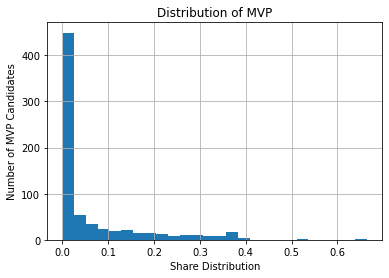

In [4]:
plt.title("Distribution of MVP")
plt.xlabel("Share Distribution")
plt.ylabel("Number of MVP Candidates")
total_df["Share"].hist(bins=26)
plt.show()

This figure shows how much the MVP shares are spread amongst all candidates in history. What we can see is that the award is very tight and competitive so it's right-skewed. However, there are 2 points at the very end of the graph. This outlier is Lebron James' 2013 award when he got almost every single 1st place vote. The other outlier is Stephen Curry's 2016 unanimous MVP season where he got all first-place votes. 

#### MVP Shares vs Pts per Game
*Purple is loser, Yellow is winner* 

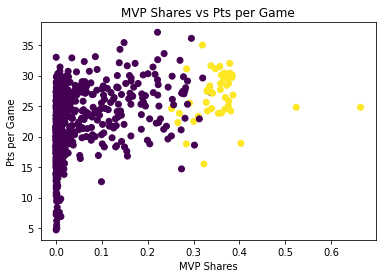

In [5]:
#Plot of MVP shares vs PPG, highlighting MVP winners
x = total_df["Share"]
y = total_df["PTS"]
plt.title("MVP Shares vs Pts per Game")
plt.xlabel("MVP Shares")
plt.ylabel("Pts per Game")
plt.scatter(x,y, c=total_df["Winner"])
plt.show()

Some things to explore are obvious. Are the players that score the most the MVP. According to the graph above, many of the players that won did not score a lot of points. Some of them did have more point game averages than the average MVP candidate. But scoring is simply not enough to dictate the MVP.

#### MVP Shares vs PER
*Purple is loser, Yellow is winner* 

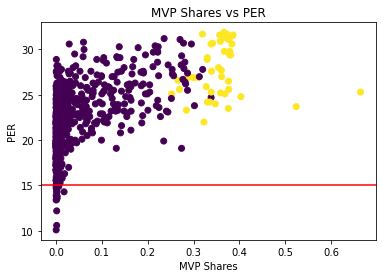

In [6]:
#Plot of MVP shares vs PER, highlighting MVP winners
x = total_df["Share"]
y = total_df["PER"]
plt.title("MVP Shares vs PER")
plt.xlabel("MVP Shares")
plt.ylabel("PER")
plt.scatter(x,y, c=total_df["Winner"])
plt.axhline(y=15, color='r', linestyle='-')
plt.show()

Another thing to consider is how efficiency relates to MVP shares. Of course, all MVPs have a higher PER than the average player. The average player is 15 and all candidates have a much higher rating. But even the players that could be the most efficient did not necessarily win MVP. So we simply cannot claim that the MVP is the most efficient player. 

#### MVP Shares vs Win/Loss
*Purple is loser, Yellow is winner* 

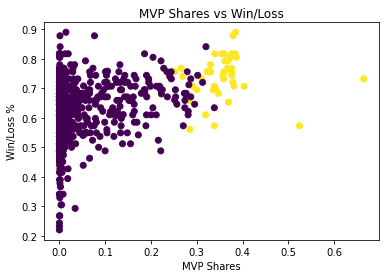

In [7]:
#Plot of MVP shares vs W/L%, highlighting MVP winners
x = total_df["Share"]
y = total_df["W/L%"]
plt.title("MVP Shares vs Win/Loss")
plt.xlabel("MVP Shares")
plt.ylabel("Win/Loss %")
plt.scatter(x,y, c=total_df["Winner"])
plt.show()

Finally, a feature to look at is, does the winningest player get the most MVP shares? According to the figure above, this also does not hold the case. Some MVP candidates did not have the most wins but they were still considered. A few even did not win much but still were able to win the award. 


### Part 3: Creating and training the model

#### Loading the Data
To obtain the dataset we will use to train and test the model we first need to remove some classifying data that is not as important to the results. In particular, we will drop the player name, team name, year, and mvp winner columns, as they do not include the actual stats we want to train/test the model with. 

In [8]:
from sklearn import svm, linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

model_df = total_df.drop(["Player","Tm","Year","Winner"],axis=1) #Drop categorical data

x_train, x_test, y_train, y_test = train_test_split(model_df.drop("Share",axis=1), 
                                        model_df["Share"], test_size = 0.3, random_state=42)


We then use train_test_split to obtain a 70-30 train/test split, i.e. 70% of the dataset will be used to train the model and 30% will be used to test the model. We have the features (x) of the data to be all remaining columns except share, which is the label (y - variable to be predicted).



#### Linear Regression Model 

In [9]:
#Linear Regression
lr = LinearRegression(fit_intercept=False)
lr.fit(x_train,y_train)
y_pred_linreg = lr.predict(x_test)

First we create the Linear Regression model using the fit_intercept parameter set to false so we have the y-intercept at 0. Training is done on the x_train and y_train datasets obtained from train_test_split, and prediction is done on the x_test dataset.

#### Support Vector Regression Model 

In [10]:
#SVM
curr_score = -1
best_c = -1
cs = [10**i for i in range(31)]
for c in cs: #Finding effective C score (prediction is 10^30 will be best)
    svr = svm.SVR(C=c)
    svr.fit(x_train,y_train)
    y_pred_svr = svr.predict(x_test)
    score = svr.score(x_train,y_train)
    if curr_score < score:
        best_c = c
print("Best c is: " + "{:e}".format(c))
#Predict using best C-score
svr = svm.SVR(C=best_c,kernel="rbf")
svr.fit(x_train,y_train)
y_pred_svr = svr.predict(x_test)


Best c is: 1.000000e+30


Next, we will create the SVR model. We want to find the best c parameter to use with this model, so we will create a for loop that trains and tests a new model each time with a different c ranging from 10^0 to 10^30, in powers of 10. The training and testing datasets are the same as those used for the Linear Regression model. Then when the optimal c is found, the SVR model will be built using this c and the kernel of RBF. Training and predictions will be done the same as was for the Linear Regression model, using x_train, y_train and x_test.

The optimal c parameter was found to be 10^30 (1e30)


### Part 4: Validating and testing the model

In order to validate and test our models, we will look at the different R-Squared and Mean Squared Error (MSE) scores for each model. The R-Squared scores can be determined using the .score() methods of each model, and the MSE scores can be determined using the mean_squared_error() function, which uses the y_test dataset and prediction dataset obtained for models. 

In [11]:
# Comparing linreg and SVM model R^2 and MSE values
score_linreg = lr.score(x_train,y_train)
print("Linear Regression R-squared:", score_linreg)
print("Linear Regression MSE:", mean_squared_error(y_test, y_pred_linreg))
score_svr = svr.score(x_train,y_train)
print("SVR R-squared:", score)
print("SVR MSE:", mean_squared_error(y_test, y_pred_svr))

Linear Regression R-squared: 0.5597029962649636
Linear Regression MSE: 0.005752819679902886
SVR R-squared: 0.6142067700082494
SVR MSE: 0.009831518863631228


The R-Squared score for the SVR model turned out to be better than that of the Linear Regression model. However, the opposite was true for the MSE score, as the Linear Regression model had a better MSE than the SVR model.

### Part 5: Determining the MVP
Finally, the MVP will be determined for this season using the model created.

#### Prepare 2021-22 data to be able to make a prediction

In [12]:
final_df_22.set_index("Player",inplace=True)
final_df_22.drop(["Tm"],axis=1,inplace=True)
final_df_22.dropna(inplace=True)
final_df_22_LR = final_df_22.copy()
final_df_22_SVR = final_df_22.copy()

#### Making The Predictions

In [13]:
#Predict using both models
final_df_22_LR["Share"] = lr.predict(final_df_22)
final_df_22_SVR["Share"] = svr.predict(final_df_22)

#### Linear Regression Predictions

In [14]:
#Create final list of voting shares for 2021-22 season using LinReg prediction
final_df_22_LR.sort_values(by="Share",ascending=False,inplace=True)
final_df_22_LR.to_csv("21-22_Test_Results_LinReg.csv", encoding = "ISO-8859-1")
final_df_22_LR = pd.read_csv("21-22_Test_Results_LinReg.csv")
final_df_22_LR.head(10)

,Player,PER,TS%,USG%,WS,OBPM,DBPM,VORP,FG%,TRB,AST,STL,BLK,TOV,PTS,W/L%,Share
0,Nikola Jokić,32.8,0.661,31.9,15.2,9.2,4.5,9.8,0.583,13.8,7.9,1.5,0.9,3.8,27.1,0.585,0.224838
1,Giannis Antetokounmpo,32.1,0.633,34.9,12.9,7.6,3.5,7.4,0.553,11.6,5.8,1.1,1.4,3.3,29.9,0.622,0.186720
2,Joel Embiid,31.2,0.616,37.2,12.0,7.2,2.0,6.5,0.499,11.7,4.2,1.1,1.5,3.1,30.6,0.622,0.133764
3,Luka Dončić,25.1,0.571,37.4,7.6,6.4,1.8,5.9,0.457,9.1,8.7,1.2,0.6,4.5,28.4,0.634,0.111913
4,Ja Morant,24.4,0.575,33.7,6.7,6.2,-0.1,3.9,0.493,5.7,6.7,1.2,0.4,3.4,27.4,0.683,0.074730
5,Kevin Durant,25.6,0.634,31.2,8.4,6.4,0.7,4.8,0.518,7.4,6.4,0.9,0.9,3.5,29.9,0.537,0.055429
6,Devin Booker,21.3,0.576,32.0,7.6,3.9,0.2,3.6,0.466,5.0,4.8,1.1,0.4,2.4,26.8,0.780,0.043448
7,Jayson Tatum,21.8,0.578,32.1,9.6,4.3,0.6,4.8,0.453,8.0,4.4,1.0,0.6,2.9,26.9,0.622,0.041676
8,Trae Young,25.4,0.603,34.4,10.0,7.1,-2.0,4.8,0.460,3.7,9.7,0.9,0.1,4.0,28.4,0.524,0.039177
9,Chris Paul,20.8,0.581,19.7,9.4,3.1,2.3,4.0,0.493,4.4,10.8,1.9,0.3,2.4,14.7,0.780,0.034325


#### Support Vector Regression Prediction

In [15]:
#Create final list of voting shares for 2021-22 season using SVR prediction
final_df_22_SVR.sort_values(by="Share",ascending=False,inplace=True)
final_df_22_SVR.to_csv("21-22_Test_Results_SVR.csv", encoding = "ISO-8859-1")
final_df_22_SVR = pd.read_csv("21-22_Test_Results_SVR.csv")
final_df_22_SVR.head(10)

,Player,PER,TS%,USG%,WS,OBPM,DBPM,VORP,FG%,TRB,AST,STL,BLK,TOV,PTS,W/L%,Share
0,Nikola Jokić,32.8,0.661,31.9,15.2,9.2,4.5,9.8,0.583,13.8,7.9,1.5,0.9,3.8,27.1,0.585,0.421867
1,Giannis Antetokounmpo,32.1,0.633,34.9,12.9,7.6,3.5,7.4,0.553,11.6,5.8,1.1,1.4,3.3,29.9,0.622,0.319850
2,Joel Embiid,31.2,0.616,37.2,12.0,7.2,2.0,6.5,0.499,11.7,4.2,1.1,1.5,3.1,30.6,0.622,0.268774
3,Domantas Sabonis,21.9,0.637,22.3,7.1,3.2,0.9,3.2,0.573,12.1,5.2,1.0,0.4,3.1,18.9,0.625,0.226594
4,Jalen Suggs,8.6,0.455,25.3,-1.6,-5.3,-0.2,-1.2,0.361,3.6,4.4,1.2,0.4,3.0,11.8,0.268,0.199436
5,Chris Paul,20.8,0.581,19.7,9.4,3.1,2.3,4.0,0.493,4.4,10.8,1.9,0.3,2.4,14.7,0.780,0.198798
6,Reggie Jackson,12.1,0.488,27.6,0.4,-1.4,-1.6,-0.6,0.392,3.6,4.8,0.7,0.2,2.3,16.8,0.512,0.155375
7,Deandre Ayton,21.9,0.656,21.4,7.3,2.2,0.6,2.1,0.634,10.2,1.4,0.7,0.7,1.6,17.2,0.780,0.148294
8,Robert Williams,22.1,0.745,11.5,9.9,2.4,3.1,3.4,0.736,9.6,2.0,0.9,2.2,1.0,10.0,0.622,0.144882
9,Devin Booker,21.3,0.576,32.0,7.6,3.9,0.2,3.6,0.466,5.0,4.8,1.1,0.4,2.4,26.8,0.780,0.119289


#### Visualizing Linear Regression Prediction

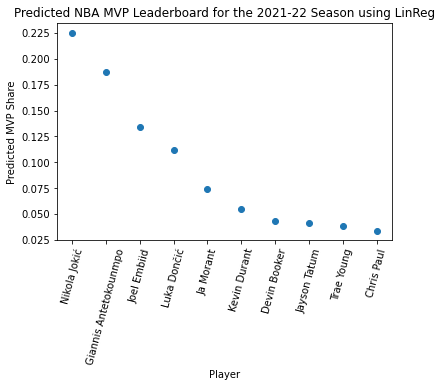

In [16]:
plt.scatter("Player","Share",data=final_df_22_LR.head(10))
plt.xlabel("Player")
plt.ylabel("Predicted MVP Share")
plt.title("Predicted NBA MVP Leaderboard for the 2021-22 Season using LinReg")
plt.xticks(rotation=75)
plt.show()

#### Visualizing Support Vector Regression Prediction

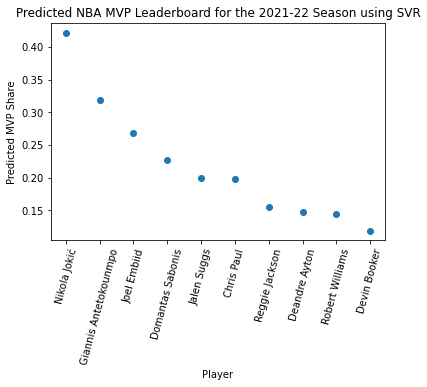

In [17]:
plt.scatter("Player","Share",data=final_df_22_SVR.head(10))
plt.xlabel("Player")
plt.ylabel("Predicted MVP Share")
plt.title("Predicted NBA MVP Leaderboard for the 2021-22 Season using SVR")
plt.xticks(rotation=75)
plt.show()

### Conclusion
After cleaning our data, doing some EDA, and creating and evaluating our models, we finally see what results the models give us. Both models give us the same Top 3 (Jokić, Antetokounmpo, and Embiid), which is accurate as it matches the finalists for this year. However, we believe the Linear Regression model did a much better job at predicting the rest of the Top 10, featuring many of this year’s top players. The SVR model did well, but did include some surprises, including big man Domantas Sabonis, who is unlikely to even make an All-NBA team this year, and inefficient rookie Jalen Suggs. A notable absence on both charts was Stephen Curry, who we think will receive several MVP votes and project as a Top-5 finisher. Overall, the predicted MVP winner is Nikola Jokić.